In [1]:
import argparse
import time
import pdb

from anndata import AnnData
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

from data import DatasetWithConfounder
from models import BatchDecoder
from models import HilbertSchmidtAE
from utils import configure_logging
from utils import embed_data, train
from utils import load_data
from utils import set_seeds

from desc_ethan import desc
import scvi
import shutil
from pathlib import Path

from utils import silhouette
from tqdm import tqdm
import pandas as pd
import numpy as np

from utils import ebm, knn_purity

configure_logging()
set_seeds(12345)

In [2]:
excluded_cells = []

In [3]:
#for dataset in ["pancreas_generalization", "pbmc_generalization"]:
for dataset in ["covid_generalization"]:
    adata = load_data(dataset, normalized=True)
    adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")
    adata.obs["study"] = adata.obs["study"].astype("category")

    if dataset == "covid_generalization":
        source_batches = ['HC1', 'HC2', 'HC3']
        source_adata = adata[adata.obs["study"].isin(source_batches)]
        target_adata = adata[~adata.obs["study"].isin(source_batches)]
        source_adata = source_adata[~source_adata.obs["cell_type"].isin(excluded_cells)]
        query_adata = target_adata[target_adata.obs["study"].isin(["S1"])]

    train_set = DatasetWithConfounder(X=source_adata.X.copy(), Z=LabelEncoder().fit_transform(source_adata.obs.study))
    train_loader = DataLoader(train_set, batch_size=128, shuffle=True)


    decoder_class = BatchDecoder

    model = HilbertSchmidtAE(
        decoder_class(
            configuration={
                "layer_sizes": [adata.X.shape[1], 500, 250, 50],
                "lr": 1e-3,
                "num_batches": len(adata.obs['study'].unique()),
            }
        ),
        configuration={
            "lambda": 1,
        }
    )

    t0 = time.time()
    train(model, train_loader, 100, logging_interval=5)
    print('{} seconds'.format(time.time() - t0))

    eval_adata = AnnData.concatenate(source_adata, target_adata)

    eval_set = DatasetWithConfounder(X=eval_adata.X.copy(), Z=LabelEncoder().fit_transform(eval_adata.obs.study))
    eval_loader = DataLoader(eval_set, batch_size=128)
    results = embed_data(model, eval_loader)

    hd_md_eval_embeddings = AnnData(X=results, obs={
        "study":eval_adata.obs["study"].values,
        "cell_type":eval_adata.obs["cell_type"].values
    })

    hd_md_eval_embeddings.obs["cell_type"] = hd_md_eval_embeddings.obs["cell_type"].astype("category")
    hd_md_eval_embeddings.obs["study"] = hd_md_eval_embeddings.obs["study"].astype("category")

    hd_md_eval_embeddings.write("results/{}/hd-md_generalization.h5ad".format(dataset))
    
    """
    source_adata = desc.scale_bygroup(source_adata, groupby="study", max_value=6)
    query_adata = desc.scale_bygroup(query_adata, groupby="study", max_value=6)
    eval_adata_desc = AnnData.concatenate(source_adata, query_adata)
    
    model_cache_dir = Path("test")
    if model_cache_dir.exists() and model_cache_dir.is_dir():
        print("Removing cached result")
        shutil.rmtree(model_cache_dir)
    
    desc_results, desc_model = desc.train(
        source_adata,
        save_dir=str(model_cache_dir),
        louvain_resolution=[0.6] if dataset == "pbmc_generalization" else [0.2],
        verbose=False
    )

    desc_eval_embeddings = AnnData(X=desc_model.extract_features(eval_adata_desc.X), obs={
        "study":eval_adata_desc.obs["study"].values,
        "cell_type":eval_adata_desc.obs["cell_type"].values
    })

    desc_eval_embeddings.obs["cell_type"] = desc_eval_embeddings.obs["cell_type"].astype("category")
    desc_eval_embeddings.obs["study"] = desc_eval_embeddings.obs["study"].astype("category")
    desc_eval_embeddings.write("results/{}/desc_generalization.h5ad".format(dataset))
    """

/homes/gws/ewein/miniconda3/envs/batch_effects/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
2021-02-16 16:37:53 INFO     Epoch 5 of 100, Train Loss: 0.044
2021-02-16 16:37:53 INFO     Reconstruction loss, hsic: 0.044934, 0.001148
2021-02-16 16:38:04 INFO     Epoch 10 of 100, Train Loss: 0.039
2021-02-16 16:38:04 INFO     Reconstruction loss, hsic: 0.036411, 0.001020
2021-02-16 16:38:14 INFO     Epoch 15 of 100, Train Loss: 0.036
2021-02-16 16:38:14 INFO     Reconstruction loss, hsic: 0.034134, 0.000913
2021-02-16 16:38:25 INFO     Epoch 20 of 100, Train Loss: 0.033
2021-02-16 16:38:25 INFO     Reconstruction loss, hsic: 0.033479, 0.000938
2021-02-16 16:38:36 INFO     Epoch 25 of 100, Train Loss: 0.032
2021-02-16 16:38:36 INFO     Reconstruction loss, hsic: 0.029731, 0.000849
2021-02-16 16:38:4

214.3224174976349 seconds


In [4]:
import scanpy as sc

data = load_data('covid_generalization', True)
data = data[data.obs['study'].isin(['HC1', 'HC2', 'HC3', 'HC4', 'S1', 'S2'])]

sc.pp.neighbors(data)
sc.tl.umap(data)

sc.pl.umap(data, color='study')
sc.pl.umap(data, color='cell_type')

         Falling back to preprocessing with `sc.pp.pca` and default params.


... storing 'study' as categorical
... storing 'cell_type' as categorical


In [49]:
from utils import load_results

results = load_results('hd-md_generalization', 'covid_generalization')
results = results[results.obs['study'].isin(['HC1', 'HC2', 'HC3', 'HC4', 'M1', 'M2', 'M3', 'S1', 'S2', 'S3', 'S4'])]

/homes/gws/ewein/miniconda3/envs/batch_effects/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [50]:
print(results.obs['cell_type'].unique())

['Macrophages', 'mDC', 'T', 'NK', 'B', 'Epithelial', 'pDC', 'Plasma', 'Mast', 'Neutrophil']
Categories (10, object): ['Macrophages', 'mDC', 'T', 'NK', ..., 'pDC', 'Plasma', 'Mast', 'Neutrophil']


In [51]:
results.obs['cell_type'].value_counts()

Macrophages    47208
T               6552
Epithelial      3019
Neutrophil      1533
NK               959
mDC              958
Plasma           223
B                186
pDC              151
Mast              58
Name: cell_type, dtype: int64

In [55]:
results = results[results.obs['cell_type'] == 'Macrophages']

results.obs['study'].value_counts()

/homes/gws/ewein/miniconda3/envs/batch_effects/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


S2     12765
S1      9829
HC2     7943
HC1     7915
M1      2177
M2      2060
HC3     1998
S4      1087
HC4      683
S3       635
M3       116
Name: study, dtype: int64

In [56]:
import scanpy as sc

sc.pp.neighbors(results)
sc.tl.umap(results)

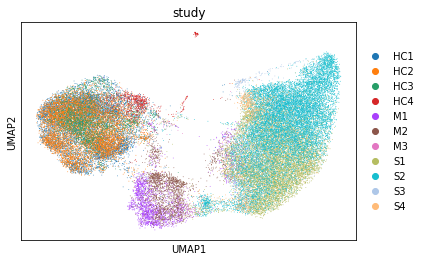

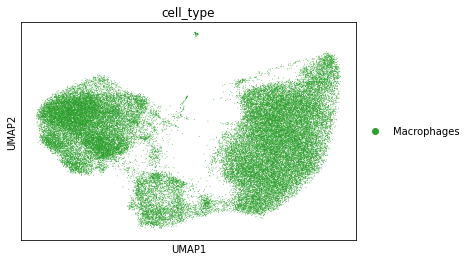

In [57]:
%matplotlib inline
sc.pl.umap(results, color='study')
sc.pl.umap(results, color='cell_type')